# GPT finetuning 해보기



## 문서요약 fine-tuning하기
- 전체 문서의 내용을 입력으로 줬을때, `생성 요약문 작성`
- 법률 문서 : 법원 판결문 뉴스 텍스트 및 법원 주요 판결문 텍스트


### ✨ 실습 개요 <br>

1) 실습 목적 <br>
- 이번 실습에서는 GPT-2 모델을 PyTorch를 사용하여 구현하고 fine-tuning 해봅니다.
- GPT 모델은 decoder-only 구조를 통해, 자연어 처리에서 뛰어난 성능을 보여주는 모델으로 GPT 모델의 구조와 downstream task 에서의 fine-tuning 방식을 이해하고, 학습이 이뤄지는 과정을 학습해봅니다

</font></b>

2) 수강 목표 <br>
  * GPT 모델의 구조와 fine-tuning 방법을 이해한다
  * GPT 모델을 문서 요약을 위한 모델로 fine-tuning하고, 학습 과정에서 일어나는 연산과 input/output 형태에 대해 이해한다
  * GPT 모델을 원하는 downstream task로 tuning 하여 사용할 수 있다


#### 실습 목차

1. Dataset & Tokenizing
  * 1-1. summ_dataset class 정의
  * 1-2. load_Data, tokenized_dataset 함수 정의
  * 1-3. prepare_dataset 함수 정의
2. Model & Trainer
  * 2-1. compute_metrics 함수 정의 (rouge)
  * 2-2. load_tokenizer_and_model_for_train 함수 정의
  * 2-3. load_trainer_for_train 함수 정의
  * 2-4. train 함수 정의
  * 2-5. arguments 지정 및 학습 진행
3. Inference & Evaluation
  * 3-1. load_model_for_inference 함수 정의
  * 3-2. inference 함수 정의
  * 3-3. infer_and_eval 함수 정의

### ⚙️ 데이터 및 환경설정
- fine tuning 할 학습(train) 데이터와 평가(test) 데이터를 불러옵니다.
- 베이스라인에 필요한 라이브러리들을 설치합니다.
- 런타임 유형을 GPU로 설정합니다.

###### 데이터 다운로드

- 아래코드 실행후 좌측 "파일" Tab 내 train.csv , test.csv 확인하기

In [ ]:

!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv' -O train.csv
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1wMhyqoJ0D7xQepW4y7Ireq2U2X61ndYz' -O test.csv


--2023-11-12 17:58:25--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2023-11-12 17:58:25--  https://docs.google.com/uc?export=download&id=14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv
Resolving docs.google.com (docs.google.com)... 142.250.145.101, 142.250.145.139, 142.250.145.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.145.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bomlaqa7lp04i9bp6oga2lsdrhfdif91/1699811850000/12384131365991006383/*/14s5orP5j6nNOqdmGdy6DkdyhcIsn-6Zv?e=download&uuid=342e550a-5576-4540-bc42-a595e33cdde0 [following]
--2023-11-12 17:58:26--  https://doc-0o-9c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bomlaqa7lp04i9bp6oga2lsdrh

[참고용]
- 원본 데이터 링크 : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=97
- 데이터셋 분리 코드 : https://colab.research.google.com/drive/1R1sioDOOAMpUASkadBbGnPL6ZuBKdGf9?usp=sharing
- 데이터셋 저장 드라이브 : https://drive.google.com/drive/folders/1M3BUMRIN4o1EFceKtJowfIvNhet_Fsbb?usp=sharing

###### 환경설정



```
pytorch_lightning
torch
pandas
numpy
transformers
sklearn
evaluate
```
- 코랩에서는 pytorch_lightning과 transformers 만 설치


In [ ]:
!pip install pytorch_lightning
!pip install transformers
!pip install transformers[torch]
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
  Preparing metadata 

- "런타임" > "런타임유형변경" > "Python3, T4 GPU" 선택

[링크 텍스트](https:// [링크 텍스트](https://))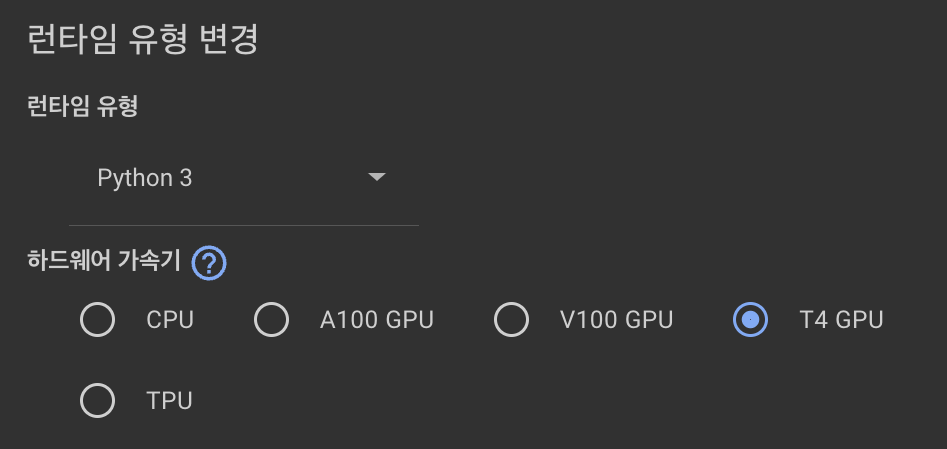

In [ ]:
import torch
torch.cuda.is_available() # GPU 할당여부 확인

True

### 1️⃣ Dataset & Tokenizing
- torch.utils.data.Dataset class 를 상속받아 summ_dataset class를 정의해줍니다.
- 데이터를 불러오는 load_data 와 tokenizing을 진행하는 <br> tokenized_dataset 를 정의해줍니다.
-  위에서 정의된 함수들을 활용하여, 데이터셋을 불러와 tokenizing 한후에, <br> torch dataset class로 변환해줍니다.
- 이후 train data /validation data 는 7.5 : 2.5로 나눠줍니다.

####1-1. <b> summ_dataset class </b> 정의

In [ ]:
import os
import pandas as pd
import torch

class summ_dataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, document, tokenizer):
      self.dataset = document
      self.tokenizer = tokenizer

    def __getitem__(self,idx):
        input_ids=torch.LongTensor(self.dataset["input_ids"][idx])
        labels=torch.LongTensor(self.dataset["labels"][idx])
        attention_mask=input_ids.ne(self.tokenizer.pad_token_id)

        return dict(input_ids=input_ids,
                    labels=labels,
                    attention_mask=attention_mask)

    def __len__(self):
        return len(self.dataset["input_ids"])

####1-2. <b>load_data , construct_tokenized_dataset</b> 함수 정의
- "데이터를 불러오고" "토크나이징 해주는" 함수들

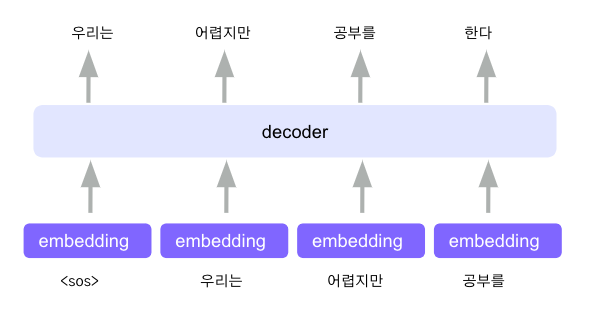

In [ ]:
import copy
def load_data(dataset_dir):
    """csv file을 dataframe으로 load"""
    dataset = pd.read_csv(dataset_dir)
    return dataset


def tokenized_dataset(dataset, doc_tokenizer, sum_tokenizer, doc_max_length, sum_max_len, mode="train"):
    """ 데이터 토크나이징"""
    if mode == "infer":
      # inference 시에는 document 만 주어지고, 마지막에 bos_token 을 붙여 생성 시작
      document_text = dataset['document']
      summ_text = dataset['summary']
      # <pad> <pad> d_1 d_2 d_3 ... d_n <bos>
      document = [doc_tokenizer(documents, padding = 'max_length', truncation=True, max_length=doc_max_length-1, add_special_tokens=True)['input_ids'] + [doc_tokenizer.bos_token_id] for documents in document_text.values]
      # labels 에는 요약문만큼의 빈칸으로 채워준 후 모델이 예측하도록 함
      labels = [[-100] * sum_max_len for _ in document]

      out = {"input_ids": document, "labels": labels}
      print("inference을 위한 데이터에서 tokenizing 된 input 형태")
      print(document[-1])
      print(doc_tokenizer.convert_ids_to_tokens(document[-1]))

    elif mode == "train":
      document_text = dataset['document']
      summary_text = dataset['summary']
      # document 와 summary를 이어 붙여서 모델 학습에 사용. document 뒤에는 bos_token 을 붙여 생성 시작을 명시하고, summary 를 붙인 후 맨 뒤에는 eos_token 으로 생성의 끝을 명시
      # document를 padding 할 때는 side를 left로 주고, summary를 padding 할 때는 side를 right 로 주어 연속된 문장이 생성될 수 있도록 함
      # <pad> <pad> d_1 d_2 d_3 ... d_n <bos> s_1 s_2 ... s_m <eos>
      document = [doc_tokenizer(documents, padding = 'max_length', truncation=True, max_length=doc_max_length-1, add_special_tokens=True)['input_ids'] + [doc_tokenizer.bos_token_id] for documents in document_text.values]
      summary = [sum_tokenizer(summaries + sum_tokenizer.eos_token, padding = 'max_length',truncation=True, max_length=sum_max_len, add_special_tokens=True)['input_ids'] for summaries in summary_text.values]

      # 구성해둔 document 와 summary를 결합하여 input 준비
      tokenized_senetences = [document + summary for (document, summary) in zip(document, summary)]
      # output 에는 document 길이만큼 -100 을 주어 학습에서 제외시키고, summary만을 학습하도록 준비
      # Input : <pad> <pad> d_1  d_2  d_3  ... d_n  <bos> s_1 s_2 ... s_m <eos>
      # Label : -100  -100    -100 -100 -100  ... -100  -100  s_1 s_2 ... s_m <eos>

      # Q. 다음 Token을 생성하도록 학습해야 되니까 s_1의 label은 한 칸씩 밀린 s_2가 들어가야 되지 않나요?
      # A. Transformer 라이브러리의 GPT 구현(https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L1103-L1104)을 보면, 모델의 Logit을 [: -1]만 가져오고, Label은 [1: ]을 가져와서 Loss를 계산하게 됩니다.
      # 즉, Input과 Label이 한 칸씩 밀린채로 입력을 넣지 않아도, 내부 구현에 의해 자동으로 밀린 채로 계산이 됩니다.

      labels = [[-100] * len(document) + summary for (document, summary) in zip(document, summary)]
      # padding 된 부분이 학습되지 않도록 -100 으로 치환
      labels = [[-100 if token == sum_tokenizer.pad_token_id else token for token in l] for l in labels]
      out = {"input_ids": tokenized_senetences, "labels": labels}

      print("학습을 위한 데이터에서 tokenizing 된 input 형태")
      print(tokenized_senetences[-1])
      print(doc_tokenizer.convert_ids_to_tokens(tokenized_senetences[-1]))
      print("학습을 위한 데이터에서 label의 형태")
      print(labels[-1])

    return out

####1-3. prepare_dataset 함수 정의
- 앞서 정의한 함수들 기반으로 데이터셋 준비하는 함수

🌟 전처리과정 🌟<blockquote>
1. train.csv / test.csv 파일을 pd.dataframe 로 다운로드 해준다. <br>
2. train/validation set을 나눠준다. (7.5:2.5) <br>
3. 전체 문서와 요약 데이터를 모두 tokenizing 해준다.  <br>
4. 요약(label) 데이터는 Padding 된 부분은 loss 가 흐르지 않도록 -100 으로 치환해준다. <br>
5. tokenizing 된 데이터를 summ_dataset class로 반환해준다. <br>

In [ ]:
from torch.utils.data import DataLoader

def prepare_dataset(dataset_dir, doc_tokenizer,sum_tokenizer,doc_max_len, sum_max_len):
    """학습(train)과 평가(test)를 위한 데이터셋을 준비"""
    # load_data
    train_dataset = load_data(os.path.join(dataset_dir, "train.csv"))
    test_dataset = load_data(os.path.join(dataset_dir, "test.csv"))

    # split train / validation = 7.5 : 2.5
    train_dataset, val_dataset = train_test_split(train_dataset,test_size=0.2,random_state=42)

    ### tokenizer 에 들어가기 전 데이터 형태
    print("tokenizer 에 들어가는 데이터 형태")
    print(train_dataset.iloc[0])

    # tokenizing
    print("train tokenizing...")
    tokenized_train =tokenized_dataset(train_dataset, doc_tokenizer,sum_tokenizer, doc_max_len, sum_max_len)
    print("valid tokenizing...")
    tokenized_val =tokenized_dataset(val_dataset, doc_tokenizer,sum_tokenizer, doc_max_len, sum_max_len)
    print("test tokenizing...")
    tokenized_test = tokenized_dataset(test_dataset, doc_tokenizer,sum_tokenizer, doc_max_len, sum_max_len, mode="infer")

    # make dataset for pytorch.
    summ_train_dataset = summ_dataset(tokenized_train, doc_tokenizer)
    summ_val_dataset = summ_dataset(tokenized_val, doc_tokenizer)
    summ_test_dataset = summ_dataset(tokenized_test, doc_tokenizer)

    print("--- dataset class Done ---")

    return summ_train_dataset , summ_val_dataset, summ_test_dataset, test_dataset



### 2️⃣ Model & Trainer
- huggingface 에서 사전학습된(pre-trained) 모델을 불러옵니다.
- huggingface 의 Trainer 모듈을 정의하고 학습에 사용될 Arguments 들을 지정해줍니다.

In [ ]:
import os
import random
import numpy as np
import pytorch_lightning as pl
import torch
#from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForCausalLM,
    GPT2LMHeadModel
)
from transformers import Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import EarlyStoppingCallback
from transformers.optimization import get_cosine_with_hard_restarts_schedule_with_warmup
import evaluate
from rouge_score import rouge_scorer, scoring
import datasets

####2-1. compute_metrics 함수 정의
- 학습 중 validation 할때 사용될 평가지표 정의하는 함수
- 해당 실습에서는 Rouge Score를 Metric으로 사용

Q. Rouge Score 란?
문서 요약, 기계 번역 등의 task 에서 모델이 생성한 문장을 평가하기 위한 지표
다양한 종류의 score 가 있지만, 이 중 ROUGE-N의 F1-score(recall 과 precisiond을 반영)를 사용합니다.
- ROUGE-N : N gram에 기반하여, 모델이 생성한 요약문과 정답 요약문 중 겹치는 단어의 개수를 확인하여 생성한 요약문을 평가하는 평가지표
- ROUGE-N recall : 두 요약문 중 겹치는 N-gram의 수 / 정답 요약문의 N-gram의 수
- ROUGE-N precision : 두 요약문 중 겹치는 N-gram의 수 / 모델이 생성한 요약문의 N-gram의 수  

예) ROUGE-1 에서, 모델이 생성한 요약문(R) : "the hello a cat dog fox jumps"/ 정답 요약문 (T) : "the fox jumps" 인 경우를 가정.
- 두 요약문 중 겹치는 1-gram ['the', 'fox', 'jumps'] 이므로 ROUGE-1 recall 은 3/3, ROUGE-1 precision 은 3/7 = 0.43

In [ ]:
import torch.nn.functional as F

def compute_metrics(pred):
    # tokenizer load
    MODEL_NAME = args.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # 예측값과 정답
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    if isinstance(preds, tuple):
      preds = preds[0]

    # document 이후부터 생성된 summary 를 decode
    decoded_preds = tokenizer.batch_decode(preds[:, args.doc_max_len:], skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels[:, args.doc_max_len:], skip_special_tokens=True)

    # rouge score 계산
    metric = datasets.load_metric("rouge")
    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # ROUGE 결과를 추출
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    return {
        'Rouge-2' : result['rouge2']
        }

####2-2.load_tokenizer_and_model_for_train 함수 정의
- 학습에 사용될 토크나이저와 모델을 불러오는 함수

In [ ]:
def load_tokenizer_and_model_for_train():
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    # model과 tokenizer를 load
    MODEL_NAME = args.model_name
    doc_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,padding_side="left")
    sum_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,padding_side="right")

    # model의 hyperparameter를 setting
    model_config = AutoConfig.from_pretrained(MODEL_NAME)

    print(model_config)

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, config=model_config
    )
    print("--- Modeling Done ---")
    return doc_tokenizer, sum_tokenizer , model

####2-3.load_trainer_for_train 함수 정의
- 학습에 사용될 Trainer 모듈을 정의하고 Arguments들을 지정해준다.


In [ ]:
def load_trainer_for_train(model,summ_train_dataset,summ_val_dataset):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(
        output_dir=args.save_path + "results",  # output directory
        save_total_limit=args.save_limit,  # number of total save model.
        save_steps=args.save_step,  # model saving step.
        num_train_epochs=args.epochs,  # total number of training epochs
        learning_rate=args.lr,  # learning_rate
        per_device_train_batch_size=args.batch_size,  # batch size per device during training
        per_device_eval_batch_size=1,  # batch size for evaluation
        warmup_steps=args.warmup_steps,  # number of warmup steps for learning rate scheduler
        weight_decay=args.weight_decay,  # strength of weight decay
        logging_dir=args.save_path + "logs",  # directory for storing logs
        logging_steps=args.logging_steps,  # log saving step.
        evaluation_strategy="steps",  # evaluation strategy to adopt during training
            # `no`: No evaluation during training.
            # `steps`: Evaluate every `eval_steps`.
            # `epoch`: Evaluate every end of epoch.
        eval_steps=args.eval_steps,  # evaluation step.
        load_best_model_at_end=True,
    )

    ## Add callback & optimizer & scheduler
    MyCallback = EarlyStoppingCallback(
        early_stopping_patience=5, early_stopping_threshold=0.001
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.lr,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.weight_decay,
        amsgrad=False,
    )
    print("--- Set training arguments Done ---")
    trainer = Trainer(
        model=model,  # the instantiated 🤗 Transformers model to be trained
        args=training_args,  # training arguments, defined above
        train_dataset=summ_train_dataset,  # training dataset
        eval_dataset=summ_val_dataset,  # evaluation dataset
        compute_metrics=compute_metrics,  # define metrics function
        callbacks=[MyCallback],
        optimizers=(
            optimizer,
            get_cosine_with_hard_restarts_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=args.warmup_steps,
                    num_training_steps=len(summ_train_dataset) * args.epochs,
            ),
        ),
    )
    print("--- Set Trainer Done ---")

    return trainer


####2-4.train 함수 정의
- 실험세팅 후 앞서 정의한 함수들 활용하여 학습을 진행하는 함수

🌟 학습동작과정 🌟
<blockquote>
1. 실험에 영향을 주는 모든 seed를 고정해준다. <br>
2. 사용할 gpu를 device에 할당해준다. <br>
3. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
4. 학습에 사용될 summ_dataset 을 불러온다.<br>
5. 학습에 사용될 Trainer 를 불러온다.<br>
6. 학습을 진행한후에 best_model을 저장해준다. <br>

In [ ]:
def train():
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)


    # set model and tokenizer
    doc_tokenizer, sum_tokenizer , model = load_tokenizer_and_model_for_train()
    model.to(device)

    # set data
    summ_train_dataset, summ_val_dataset, summ_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,doc_tokenizer, sum_tokenizer,args.doc_max_len,args.sum_max_len)
    # set trainer
    trainer = load_trainer_for_train(model,summ_train_dataset,summ_val_dataset)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    model.save_pretrained("./best_model")


####2-5.arguments 지정 및 학습 진행

In [ ]:
class args():
    """학습(train)과 추론(infer)에 사용되는 arguments 관리하는 class"""
    dataset_dir = "./"
    model_type = "gpt2"
    model_name = 'MrBananaHuman/kogpt2_small'
    save_path = "./"
    save_step = 400
    logging_steps = 200
    eval_steps = 200
    save_limit = 5
    seed = 42
    epochs = 20 # 10
    batch_size = 4  # 메모리 상황에 맞게 조절 e.g) 16 or 32
    doc_max_len = 196
    sum_max_len = 64
    lr = 3e-5
    weight_decay = 0.01
    warmup_steps = 5
    scheduler = "linear"
    model_dir = "./best_model" #추론 시, 저장된 모델 불러오는 경로 설정
train()

INFO:lightning_fabric.utilities.seed:Seed set to 42


device: cuda:0


GPT2Config {
  "_name_or_path": "MrBananaHuman/kogpt2_small",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.35.0",
  "use_cache": true,
  "vocab_size": 52000
}



--- Modeling Done ---
tokenizer 에 들어가는 데이터 형태
document    [1] 甲이 토지소유자 乙에게서 토지를 임차한 후 주유소 영업을 위하여 지하에 유류...
summary     토지에 매설된 유류저장조는 토지와 일체를 이루는 구성 부분이 아니므로 토지 임차인이...
Name: 249, dtype: object
train tokenizing...
학습을 위한 데이터에서 tokenizing 된 input 형태
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12712, 600, 979, 723, 1042, 545, 3772, 1314, 13479, 12712, 1450, 1171, 7832, 979, 135, 3500, 723, 1254, 23745, 11328, 12712, 600, 979, 7303, 1172, 4658, 1036, 476, 752, 2653, 12712, 600, 979, 1667, 16747, 7832, 694, 5242, 27950, 10509, 7491, 5208, 10703, 2867, 1377, 386, 8459, 7309, 8065, 1104, 319, 5295, 14660, 12712, 600, 979, 1042, 545, 16798, 11242, 1487, 10093, 1042, 545, 2336, 1681, 1249, 5490, 1377, 386, 8459, 6650, 549, 1673, 2792, 11242, 1487, 10093, 1042, 545, 2823, 18961, 12712, 600, 29958, 56

Step,Training Loss,Validation Loss,Rouge-2
200,2.534800,2.174470,13.090900
400,1.448100,2.198148,13.241100
600,0.837900,2.277261,12.761100
800,0.471900,2.394279,12.359100
1000,0.255700,2.428395,14.846000
1200,0.147100,2.502518,14.652400
1400,0.101500,2.587926,14.773000


<ipython-input-8-864bc692db70>:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("rouge")


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


--- Finish train ---


### 3️⃣ Inference & Evaluation
- 학습완료된(fine-tuned) 모델을 불러와서 추론(infer)을 진행합니다.
- 추론된 예측값들과 정답값을 비교하여 평가(evaluation)합니다.

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
from rouge_score import rouge_scorer, scoring


####3-1.load_model_for_inference 함수 정의
- 학습된(fine-tuned) 모델의 체크포인트(checkpoint)를 불러오는 함수 <br>
<b>(이때, 토크나이저는 기존과 동일하게 huggingface 에서 불러온다. )</b>


In [ ]:
def load_model_for_inference():
    """추론(infer)에 필요한 모델과 토크나이저 load """
    # load tokenizer
    Tokenizer_NAME = args.model_name
    doc_tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME,padding_side="left")
    sum_tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME,padding_side="right")

    ## load my model
    model = GPT2LMHeadModel.from_pretrained(args.model_dir)

    return doc_tokenizer, sum_tokenizer, model

####3-2. inference 함수 정의
- 학습된(fine-tuned)모델을 통해 평가 데이터의 예측값 추론해내는 함수

🌟 추론(infer) 계산과정 🌟

<blockquote>
1. model.eval , torh.no_grad 를 통해 모델을 추론 모드로 변경 <br>
2. 모델에 입력값으로 input_ids 를 <b>gpu에 할당한 후</b> 입력으로 주고 결과값(outputs) 생성 (generate) <br>
3. 결과값(outputs) 이 요약문이므로, 다시 decode 하여 예측 레이블(label) 생성 <br>
4. 생성된 레이블(label) 을 concat 하여 리스트 형태로 반환

In [ ]:
def inference(model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    MODEL_NAME = args.model_name
    doc_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,padding_side="left")

    dataloader = DataLoader(tokenized_sent, batch_size=args.batch_size, shuffle=False)
    model.eval()
    output_pred = []
    output_score = []

    metric = datasets.load_metric("rouge")
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model.generate(
                input_ids=data["input_ids"].to(device),
                max_new_tokens = 128, # 최대 길이로 설정
                pad_token_id = doc_tokenizer.pad_token_id # "eos" 토큰이 나올 때까지 생성
            )
        # decode
        decoded_preds = doc_tokenizer.batch_decode(outputs[:, args.doc_max_len:], skip_special_tokens=True)
        output_pred.append(decoded_preds)

    return (np.concatenate(output_pred).tolist(),)


####3-3.infer_and_eval 함수 정의
- 학습된(fine-tuned) 모델로 추론(infer)한 후 예측한 결과를 평가(evaluation)하는 함수

<blockquote>
1. 사용할 gpu를 device에 할당해준다. <br>
2. tokenizer와 model을 불러온후, model을 device에 할당해준다. <br>
3. 추론에 사용될 summ_dataset 을 불러온다.<br>
4. model 과 summ_dataset을 입력으로 주고 추론(infer)을 진행한다. <br>
5. test data 의 레이블(label)과 예측값(pred)을 비교하여 평가지표를 계산한다.<br>
6. 최종 예측값을 csv 형태로 저장해준다. <br>

In [ ]:
def infer_and_eval():
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    doc_tokenizer, sum_tokenizer, model = load_model_for_inference()
    model.to(device)

    # set data
    summ_train_dataset, summ_val_dataset, summ_test_dataset, test_dataset = prepare_dataset(args.dataset_dir,doc_tokenizer, sum_tokenizer,args.doc_max_len,args.sum_max_len)
    # predict answer
    pred_answer = inference(model, summ_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    # evaluate between label and prediction
    labels = test_dataset['summary'].values
    pred = pred_answer[0]
    metric = datasets.load_metric("rouge")
    # 전체 데이터에 대한 값 계산
    result = metric.compute(predictions=pred, references=labels, use_aggregator = True)
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f" ----- rouge :{result['rouge2']} -----")

    # 각각 데이터에 대한 값 계산
    pred_scores = metric.compute(predictions=pred, references=labels, use_aggregator = False)
    pred_score = [score.fmeasure * 100 for score in pred_scores['rouge2']]

    # make csv file with predicted answer
    output = pd.DataFrame(
        {
            "document": test_dataset["document"],
            "summary_pred": pred,
            "summary_label": labels,
            "score" : pred_score
        }
    )

    # 최종적으로 완성된 예측한 라벨 csv 파일 형태로 저장.
    result_path = "./prediction/"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    output.to_csv(
        os.path.join(result_path,"result.csv"), index=False
    )
    print("--- Save result ---")
    return output

In [ ]:
output_df = infer_and_eval()
output_df.head(10)

tokenizer 에 들어가는 데이터 형태
document    [1] 甲이 토지소유자 乙에게서 토지를 임차한 후 주유소 영업을 위하여 지하에 유류...
summary     토지에 매설된 유류저장조는 토지와 일체를 이루는 구성 부분이 아니므로 토지 임차인이...
Name: 249, dtype: object
train tokenizing...
학습을 위한 데이터에서 tokenizing 된 input 형태
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12712, 600, 979, 723, 1042, 545, 3772, 1314, 13479, 12712, 1450, 1171, 7832, 979, 135, 3500, 723, 1254, 23745, 11328, 12712, 600, 979, 7303, 1172, 4658, 1036, 476, 752, 2653, 12712, 600, 979, 1667, 16747, 7832, 694, 5242, 27950, 10509, 7491, 5208, 10703, 2867, 1377, 386, 8459, 7309, 8065, 1104, 319, 5295, 14660, 12712, 600, 979, 1042, 545, 16798, 11242, 1487, 10093, 1042, 545, 2336, 1681, 1249, 5490, 1377, 386, 8459, 6650, 549, 1673, 2792, 11242, 1487, 10093, 1042, 545, 2823, 18961, 12712, 600, 29958, 5626, 13821, 7540, 1264,

100%|██████████| 125/125 [04:57<00:00,  2.38s/it]


--- Prediction done ---
 ----- rouge :4.6951 -----
--- Save result ---


,document,summary_pred,summary_label,score
0,[1] 가처분은 가처분 채무자에 대한 부작위 명령을 집행하는 것이므로가처분의 채무자...,가처분결정이 있기 전 온천이용허가권자인 온천수 사용금지 가처분결정이 있기 전 온천이...,가처분은 가처분 채무자에 대한 부작위 명령을 집행하는 것이므로 가처분의 채무자가 아...,0.0
1,구 토지개량사업법 제129조의 규정에 의하면환지인가의 고시가 있은 후에는 환지확정등...,환지확정등기는 환지확정등기가 필요하기 때문에 환지확정등기는 환지확정등기가 필요하기 ...,환지인가의 고시가 있은 후에는 환지확정등기가 필요될 때까지는 일반등기는 정지되어 환...,0.0
2,내국신용장에 의한 환어음의 관계당사자간에 적용하기로 되어있는 신용장통일규칙 제7조 ...,은행등 관계당사자는 관계서류가 신용장 조건과 문면상 일치하는지 여부를 조사하여야 할...,"신용장통일규칙 제7조, 제9조에 의해 은행등 관계당사자는 관계서류가 신용장 조건과 ...",0.0
3,"[1] 횡령죄의 주체는 타인의 재물을 보관하는 자이어야 하고,여기서 보관이라 함은 ...",임야의 진정한 소유자와는 전혀 상관없이 신탁자로부터 임야 지분을 명의신탁받아 지분이...,횡령죄가 성립하기 위하여는 그 재물의 보관자가 재물의 소유자(또는 기타의 본권자)와...,0.0
4,"[1] 경찰관은 범인의 체포,도주의 방지,자기 또는 타인의 생명·신체에 대한 방호,...","경찰관의 무기 사용이 이러한 요건을 충족하는지 여부는 범죄의 종류,범,범인과 경찰관...",경찰관이 범인을 제압하는 과정에서 총기를 사용하여 범인을 사망에 이르게 한 사안에서...,0.0
5,[1] 피고인이나 그 변호인이 검사 작성의 당해 피고인에 대한 피의자신문조서의 성립...,피고인이나 그 변호인이 검사의 피의자신문조서의 성립의 진정함을 인정하는 진술을 하였...,피고인이 피의자신문조서에 대하여 구 형사소송법 제292조의 증거조사가 완료되기 전에...,0.0
6,"어떤 문장에 있어서 반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글...","반국가 단체의 활동을 찬양,고무, 동조하는 내용의 구절 또는 글귀에는 반국가 단체의...","어떤 문장에 있어서 반국가 단체의 활동을 찬영, 동조하는 등 내용의 구절은 비록 그...",0.0
7,동장이 대로변에서 거리질서확립 캠페인중 학생들을 인솔해와 합류한 교사와 어깨띠 착용...,재량권의 범위를 일탈한 위법이므로 재량권의 범위를 일탈한 위법이므로 재량권의 범위를...,동장이 캠페인 시비로 인해 뺨을 때린 후 사과하고 캠페인을 마쳤다면 사후 정황으로 ...,0.0
8,[1] 공직선거법 제112조 제1항의 기부행위는 그에 의한 기부의 효과를 후보자 또...,공직선거법 제112조 제1항에서 기부행위는 그 출연자와 기부행위자가 되려는 자에게 ...,공직선거법 제112도 제1항의 기부행위는 출연자와 기부행위자 어느 쪽이 기부 행위자...,25.0
9,민법 제201조 제1항에 의하면선의의 점유자는 점유물의 과실을 취득한다고 규정하고 ...,"점유경작업은 그 토지로 인한 손해를 방지하기 위해 점유경작업을 시행하는 것으로, 점...","민법 제201조 제1항에 의하면 선의의 점유자는 점유물 과실의 취득을 규정하고, 토...",0.0


In [ ]:
output_df[output_df['score'] >= 80]

,document,summary_pred,summary_label,score
92,[1] 노동조합및노동관계조정법 제40조 제2항이 금지하는 '간여'란 단체교섭 또는 ...,노동조합및노동관계조정법 제40조 제2항이 금지하는 '간여'는 단체교섭 또는 쟁의행위...,노동조합및노동관계조정법 제40조 2항이 금지하는 간여에 노동조합의 노무사가 파업 이...,100.0
128,법률혼주의 및 중혼금지 원칙을 대전제로 하고 있는 우리 가족법 체계를 고려하여 보면...,군인연금법 제3조 제1항 제4호가 '사실상 혼인관계에 있던 자'를 유족연금 받을 수...,군인연금법 제3조 제1항 제4호가 규정하는 유족연금을 받을 수 있는 자로서 사실상 ...,100.0
131,[1] 구 회사정리법(2005. 3. 31. 법률 제7428호 채무자 회생 및 파산...,정리회사의 관리인이 정관에 규정된 수권자본금 한도 내에서 정리법원의 허가하에 향후 ...,구 회사정리법 및 상법에 따라 정관에 규정된 수권자본금 한도 내에서 정리법원의 허가...,100.0
153,"가. 상표등록 거절사유인,상표법 제 8 조 제 1 항 제 3 호 소정의 ""보통으로 ...","상표등록 거절사유인,상표법 제 8 조 제 1항 제 3 호 소정의 ""보통 사용하는 방...",상표법 제8조 제1항 제3호 소정의 '보통으로 사용하는 방법'의 규정은 일반소유자...,100.0
205,[1] 형법 제309조 제1항 소정의 출판물에 의한 명예훼손죄는 타인을 비방할 목적...,형법 제309조 제1항 소정의 출판물에 의한 명예훼손죄는 타인을 비방할 목적으로 신...,형법 제309조 제1항 소정의 출판물에 의한 명예훼손죄의 경우 그 성립요건으로 '비...,100.0
265,"가. 세무서장 또는 시장·군수가 국세를 부과징수하고자 할 때에는 과세표준과 세율,세...",조세행정상의 편의를 위한 훈시규정이 아니라 납세고지서에 명시하여 발부통지하도록 한 ...,국세징수법 제9조 제1항 등의 규정에 의한 납세고지서에 기재사항이 누락되었다면 해당...,100.0
342,가. 한국마사회가 실시하는 경마사업은 법인세법 제1조 제1항 단서 제1호에서 정한 ...,국세기본법 제18조 제2항에서 정한 일반적으로 납세자에게 받아들여진 국세행정의 관행...,한국마사회의 경마사업으로 인한 소득은 그 사업이 비영리법인인 위 마사회의 고유사업이...,100.0
351,가. 상소권회복 청구기간을 준수하지 못한 것이 법률의 부지로 인한 것이라는 사유는 ...,상소권회복 청구기간을 준수하지 못한 것이 법률의 부지로 인한 것이라는 사유는 동 청...,상소권회복 청구기간을 준수하지 못한 것이 법률의 부지로 인한 것이라는 사유는 동 청...,80.0
440,가. 자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 ...,자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 규칙(...,자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 규칙(...,100.0


In [ ]:
# 점수가 높은 document, pred, label, score 예시
index = 440
print("Document")
print(output_df.iloc[index]["document"])
print()

print("Prediction")
print(output_df.iloc[index]["summary_pred"])
print()

print("Label")
print(output_df.iloc[index]["summary_label"])
print()

Document
가. 자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 규칙(1982.7.31 교통부령 제724호)은 교통부장관이 관계행정기관 및 직원에 대하여 그 직무권한 행사의 지침으로 발한 행정조직 내부에 있어서의 행정명령의 성질을 가지는 것이지,법규명령의 성질을 가진 것으로 볼 수 없으므로 위 규칙이 자동차운수사업법 제31조에 의하여 보장된 행정청의 재량권을 기속할 수는 없다.나. 자동차운송사업면허를 취소할 때는 취소해야 할 공익상의 필요와 취소로 인하여 당사자가 입을 불이익을 비교형량하여 그 여부를 결정해야 할 것인 바,본건에 있어서 운송사업면허에 의한 개인택시 영업은 원고의 유일한 생계수단이었고,원고가 면허조건에 위반하여 대리운전을 시켰던 것은 요추부간판수핵탈출증으로 1주일 동안 통원치료를 받게 되어 스스로 운전을 할 수 없는 사정이 있었기 때문이었던 것으로 그 대리운전기간도 하루정도에 불과했고 그 기간중에 아무런 사고가 없었다는 등의 제반사정에 비추어 원고의 위 면허조건위반에 대해 자동차운수사업법 제31조 소정의 제재중 가장 무거운 사업면허취소의 처분을 택한 조처는 재량권의 범위를 벗어난 것이다.

Prediction
자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 규칙(1982.7.31 교통부령 제724호)은 교통부장관이 관계행정기관 및 직원에 대하여 그 직무권한 행사의 지침으로 발한 행정조직 내부에 있어서의 행정명령의 성질을 가지는 것이지, 법규명령의 성질을 가진 것으로 볼 수 없으므로 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전기사 자격요건인 운전

Label
자동차운수사업법 제31조 등의 규정에 의한 사업면허의 취소 등의 처분에 관한 규칙(1982.7.31 교통부령 제724호)은 법규명령의 성질을 가지는 것이 아니므로 행정청의 재량권을 기속할 수 없고, 자동차운송사업면허

#Reference

- [AI HUB 문서요약 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=97)
- [허깅페이스](https://huggingface.co/)

## Required Package


<font color=gray>
transformers == 4.33.3 <br>
pytorch_lightning == 2.0.9.post0 <br>
</font>




## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>